<a href="https://colab.research.google.com/github/JayNguyen-123/Customer_Email_Support_Agent/blob/main/Customer_Support_Email_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CUSTOMER SUPPORT EMAIL AGENTIC AI
Agentic AI refers to AI systems that can autonomously plan, execute, and adapt to achieve goals in dynamic environments, unlike systems that simply react to input. These systems use sophisticated reasoning to make decisions, learn from feedback, and perform actions by interacting with tools and other systems. Think of it as AI that "does" instead of just "creates" content, often working collaboratively with humans.






### Designing the Basic Chains

- Categorize Email : Identify the type of email(e.g., sales,custom inquiry,etc.)
- Research Router : Direct the email’s context to the appropriate search method.
- Search Keywords : Extract relevant keywords for gathering additional information.
- Write Draft Email : Use the research and email context to generate a thoughtful reply.
- Rewrite Router : Determine if the draft requires rewriting or further improvement.
- Draft Email Analysis : Evaluate the draft’s coherence, relevance, and tone.
- Rewrite Email : Finalize the email by refining its tone and content.

In [1]:
!pip -q install langchain-groq duckduckgo-search
!pip -q install -U langchain_community tiktoken langchainhub
!pip -q install -U langchain langgraph tavily-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.2/467.2 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 83.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packag

In [2]:
# Setting up the Environment
import os
from google.colab import userdata
from pprint import pprint
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [8]:
from langchain_groq import ChatGroq

GROQ_LLM = ChatGroq(
    model="llama-3.3-70b-versatile",
)

In [9]:
# Building Prompt Templates
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser

# Logging outputs for debugging
def write_markdown_file(content, filename):
  """
  Writes the given content as a markdown file to the local directory.

  Args:
      content: The string content to write to the file.
      filename: The filename to save the file as.
      """
  with open(f"{filename}.md", "w") as f:
    f.write(content)


### Categorizing Emails: Identify the type of email(e.g., sales,custom inquiry,etc.)

In [10]:

from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an Email Categorizer Agent. You are a master at understanding what a customer wants when they write an email and are able to categorize it in s useful way.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Conduct a comprehensive analysis of the email provided and categorize it into one of the folloeing categories:
        price_enquiry - used when someone is asking for information about pricing \
        customer_complain - used when someone is complaining about something \
        product_enquiry - used when someone is asking for information about a product features, benefit, or service but not about pricing \
        customer_feedback - used when someone is giving feedback about a product \
        off_topic - when it doesn't relate to any other category.

    Output a single category only from the type ('price_enquiry', 'customer_complain', 'product_enquiry', 'customer_feedback', 'off_topic') \
    e.g.:
         'price_enquiry'

    EMAIL CONTENT: \n\n {initial_email} \n\n
    <|eot_id|>
    <|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables = ["initial_email"],
  )

In [11]:
# Connecting the Prompt with Groq's LLM
from langchain_core.output_parsers import StrOutputParser

email_category_generator = prompt | GROQ_LLM | StrOutputParser()


In [12]:
# Testing the Email Categorization
EMAIL = """
Hi there, I am emailing to say that I had a wonderful stay at your resort last week. \n

I really appreciate what your staff did.

Thanks,
Jay
"""

result = email_category_generator.invoke({"initial_email": EMAIL})
print(result)


'customer_feedback'


### Designing a Research Router: Direct the email’s context to the appropriate search method.

In [16]:
research_router_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an expert at reading the initial email and routing web search
or directly to a draft email.

Use the following criteria to decide how to route the email:

If the initial email only requires a simple response:
- Choose 'draft_email' for questions you can easily answer,
  including prompt engineering and adversarial attacks.
- If the email is just saying thank you, etc., choose 'draft_email.'

Otherwise, use 'research_info.'

Give a binary choice 'research_info' or 'draft_email' based on the question.
Return a JSON with a single key 'router_decision' and no preamble or explanation.
Use both the initial email and the email category to make your decision.
<|eot_id|><|start_header_id|>user<|end_header_id|>
Email to route INITIAL_EMAIL: {initial_email}
EMAIL_CATEGORY: {email_category}
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
""",
    input_variables=["initial_email", "email_category"],
)


In [17]:
# Integrating the Prompt with Groq's LLM
from langchain_core.output_parsers import JsonOutputParser

research_router = research_router_prompt | GROQ_LLM | JsonOutputParser()

In [18]:
# Testing the Research Router
EMAIL = """HI there, \n
I am emailing to say that I had a wonderful stay at your resort last week. \n

I really appreciate what your staff did.

Thanks,
Paul
"""

email_category = "customer_feedback"

result = research_router.invoke({"initial_email": EMAIL, "email_category": email_category})

print(result)


{'router_decision': 'draft_email'}


### Generating Search Keywords : Extract relevant keywords for gathering additional information.

In [19]:
search_keyword_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a master at working out the best keywords for a web search
to find the most relevant information for the customer.

Given the INITIAL_EMAIL and EMAIL_CATEGORY, work out the best
keywords that will find the most relevant information to help write
the final email.

Return a JSON with a single key 'keywords' containing no more than
3 keywords, and no preamble or explanation.

<|eot_id|><|start_header_id|>user<|end_header_id|>
INITIAL_EMAIL: {initial_email}
EMAIL_CATEGORY: {email_category}
<|eot_id|><|start_header_id|>assistant<|end_header_id>
""",
    input_variables=["initial_email", "email_category"],
)



In [20]:
# Building the Search Keyword Chain
search_keyword_chain = search_keyword_prompt | GROQ_LLM | JsonOutputParser()


In [21]:
# Testing the Search Keywords Generation

EMAIL = """HI there, \n
I am emailing to say that I had a wonderful stay at your resort last week. \n

I really appreciate what your staff did.

Thanks,
Paul
"""

email_category = "customer_feedback"

result = search_keyword_chain.invoke({"initial_email": EMAIL, "email_category": email_category})

print(result)

{'keywords': ['resort', 'staff', 'hospitality']}


### Writing the Draft Email: Use the research and email context to generate a thoughtful reply.


In [22]:
draft_writer_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are the Email Writer Agent. Take the INITIAL_EMAIL below from a human that has emailed our company email address, the email_category \
    that the categorizer agent gave it, and the research from the research agent, and \
    write a helpful email in a thoughful and friendly way.

        If the customer email is 'off_topic' then ask them questions to get more information.
        If the customer email is 'customer_complaint' then try to assure we value them and that we are addressing their issues.
        If the customer email is 'customer_feedback' then thank them and acknowledge their feedback positively.
        If the customer email is 'product_enquiry' then try to give them the infor the researcher provided in a succinct and friendly way.
        If the customer email is 'price_enquiry' then try to give them the pricing infor they requested.

        You never make up information that hasn't been provided by the research_info or in the initial_email.
        Always sign off the emails in an appropriate manner and from Kathy, the General Manager.

        Return the email as a JSON with a single key 'email_draft' and no preamble or explanation.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    INITIAL_EMAIL: {initial_email}
    EMAIL_CATEGORY: {email_category}
    RESEARCH_INFO: {research_info}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["initial_email", "email_category", "research_info"],
)

In [23]:
# Building the Draft Email Chain
draft_writer_chain = draft_writer_prompt | GROQ_LLM | JsonOutputParser()

In [24]:
# Testing the Draft Email Writer
email_category = "customer_feedback"
research_info = None

result = draft_writer_chain.invoke({
    "initial_email": EMAIL,
    "email_category": email_category,
    "research_info": research_info
})

print(result)


{'email_draft': 'Dear Paul, \n\nWe are thrilled to hear that you had a wonderful stay at our resort and that our staff were able to make a positive impact on your experience. We really appreciate you taking the time to share your kind words with us. \n\nThank you again for your feedback and for choosing to stay with us. We hope to have the opportunity to welcome you back again in the future. \n\nBest regards, \nKathy, General Manager'}


### Rewrite Router: Determine if the draft requires rewriting or further improvement.

In [25]:
rewrite_router_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an expert at evaluating emails that are draft emails for the customer and deciding if they
    need to be rewritten to be better. \n

    Use the following criteria to decide if the DRAFT_EMAIL needs to be rewritten: \n\n

    If the INITIAL_EMAIL only requires a simple response which the DRAFT_EMAIL contains, then it doesn't need to be rewritten.
    If the DRAFT_EMAIL addresses all the concerns of the INITIAL_EMAIL, then it doesn't need to be rewritten.
    If the DRAFT_EMAIL is missing information that the INITIAL_EMAIL requires, then it needs to be rewritten.

    Give a binary choice 'rewrite' (for needs to be rewritten) or 'no_rewrite' (for doesn't need to be rewritten) based on the DRAFT_EMAIL and the criteria.
    Return a JSON with a single key 'router_decision' and no preamble or explanation. \
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    INITIAL_EMAIL: {initial_email} \n
    EMAIL_CATEGORY: {email_category} \n
    DRAFT_EMAIL: {draft_email} \n
    <|eot_id|><|start_header_id|>assistant<|end_header_id>""",
    input_variables=["initial_email", "email_category", "draft_email"],
)


In [26]:
# Building the Rewrite Router
rewrite_router = rewrite_router_prompt | GROQ_LLM | JsonOutputParser()


In [27]:
# Testing the Rewrite Router
email_category = "customer_feedback"
draft_email = "Yo we can't help you, best regards Sarah"

result = rewrite_router.invoke({
    "initial_email": EMAIL,
    "email_category": email_category,
    "draft_email": draft_email
})

print(result)


{'router_decision': 'rewrite'}


### Draft Email Analysis: Evaluate the draft’s coherence, relevance, and tone.

In [28]:
draft_analysis_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are the Quality Control Agent. Read the INITIAL_EMAIL below from a human that has emailed \
    our company email address, the email_category that the categorizer agent gave it, and the \
    research from the research agent, and write an analysis of the email.

    Check if the DRAFT_EMAIL addresses the customer's issues based on the email category and the \
    content of the initial email.\n

    Give feedback on how the email can be improved and what specific things can be added or changed \
    to make the email more effective at addressing the customer's issues.

    You never make up or add information that hasn't been provided by the research_info or in the initial_email.

    Return the analysis as a JSON with a single key 'draft_analysis' and no preamble or explanation.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    INITIAL_EMAIL: {initial_email} \n\n
    EMAIL_CATEGORY: {email_category} \n\n
    RESEARCH_INFO: {research_info} \n\n
    DRAFT_EMAIL: {draft_email} \n\n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email", "email_category", "research_info", "draft_email"],
)


In [29]:
# Building the Draft Analysis Chain
draft_analysis_chain = draft_analysis_prompt | GROQ_LLM | JsonOutputParser()


In [30]:
# Testing the Draft Analysis Chain
email_category = "customer_feedback"
research_info = None
draft_email = "Yo we can't help you, best regard Kathy"

email_analysis = draft_analysis_chain.invoke({
    "initial_email": EMAIL,
    "email_category": email_category,
    "research_info": research_info,
    "draft_email": draft_email
})

pprint(email_analysis)


{'draft_analysis': {'feedback': 'The draft email does not address the '
                                "customer's issues as it is a negative "
                                'response to a positive feedback email. The '
                                'customer is expressing appreciation for their '
                                'stay and the staff, but the draft email is '
                                'dismissive and unhelpful. To improve the '
                                'email, it should be changed to a positive and '
                                'thankful response, such as acknowledging the '
                                "customer's appreciation and expressing "
                                'gratitude for their feedback. The tone should '
                                'be friendly and courteous, and the email '
                                'should be signed with a more professional '
                                "closing than 'best regard'.",
          

### Rewrite Email : Finalize the email by refining its tone and content.

In [31]:
rewrite_email_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are the Final Email Agent. Read the email analysis below from the QC Agent \
    and use it to rewrite and improve the draft_email to create a final email.

    You never make up or add information that hasn't been provided by the research_info or in the initial_email.

    Return the final email as JSON with a single key 'final_email' which is a string and no preamble or explanation.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    EMAIL_CATEGORY: {email_category} \n\n
    RESEARCH_INFO: {research_info} \n\n
    DRAFT_EMAIL: {draft_email} \n\n
    DRAFT_EMAIL_FEEDBACK: {email_analysis} \n\n
    <|eot_id|>""",
    input_variables=["initial_email", "email_category", "research_info", "email_analysis", "draft_email"],
)


In [32]:
# Building the Rewrite Chain
rewrite_chain = rewrite_email_prompt | GROQ_LLM | JsonOutputParser()

In [33]:
# Testing the Rewrite Email Chain
email_category = 'customer_feedback'
research_info = None
draft_email = "Yo we can't help you, best regards Sarah"

final_email = rewrite_chain.invoke({
    "initial_email": EMAIL,
    "email_category": email_category,
    "research_info": research_info,
    "draft_email": draft_email,
    "email_analysis": email_analysis
})

print(final_email['final_email'])


Dear valued customer, we appreciate your kind words about your stay and our staff. Thank you for taking the time to share your positive feedback with us. We are grateful for customers like you and look forward to serving you again in the future. Sincerely, Sarah


### Tool Setup
The TavilySearchResults tool is set up to handle web searches and retrieve relevant results.

In [98]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=1)

In [69]:
# State Setup
from langchain_core.documents import Document
from langgraph.graph import END, StateGraph
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
  """
  Represents the state of our graph.

  Attributes:
      initial_email: email
      email_category: email category
      research_info: list of documents
      draft_email: LLM generation
      final_email: LLM generation
      info_needed: whether to add search infor
      num_steps: number of steps
  """
  initial_email: str
  email_category: str
  draft_email: str
  final_email: str
  research_info: List[str]
  info_needed: bool
  num_steps: int
  draft_email_feedback: dict


### Categorize Email


In [70]:
def categorize_email(state):
  """ Take the initial email and categorize it"""
  print("----CATEGORIZE INITIAL EMAIL----")
  initial_email = state['initial_email']
  num_steps = int(state['num_steps'])
  num_steps += 1

  # Categorize the email
  email_catgory = email_category_generator.invoke({'initial_email': initial_email})
  print(email_category)

  # Save category to local disk
  write_markdown_file(email_category, 'email_category')

  return {"email_category": email_category, "num_steps": num_steps}


### Research Info Search


In [87]:
def research_info_search(state):
    print("---RESEARCH INFO SEARCHING---")
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    research_info = state["research_info"]
    num_steps = state['num_steps']
    num_steps += 1

    # Web search for keywords
    keywords = search_keyword_chain.invoke({"initial_email": initial_email,
                                            "email_category": email_category })
    keywords = keywords['keywords']

    full_searches = []
    for keyword in keywords[:1]:  # Only taking the first keyword
        print(keyword)
        temp_docs = web_search_tool.invoke({"query": keyword})
        web_results = "\n".join([d["content"] for d in temp_docs])
        web_results = Document(page_content=web_results)
        if full_searches is not None:
            full_searches.append(web_results)
        else:
            full_searches = [web_results]
    print(full_searches)
    print(type(full_searches))

    return {"research_info": full_searches, "num_steps": num_steps}


### Draft Email Writer: This function creates a draft email based on the initial email, email category, and research info.

In [88]:

def draft_email_writer(state):
  print("----DRAFT EMAIL WRITER----")

  # Get the state
  initial_email = state["initial_email"]
  email_category = state["email_category"]
  research_info = state["research_info"]
  num_steps = state["num_steps"]
  num_steps += 1

  # Generate draft email using the draft_writer_chain
  draft_email = draft_writer_chain.invoke({"initial_email": initial_email,
                                           "email_category": email_category,
                                           "research_info": research_info})
  print(draft_email)

  email_draft = draft_email["email_draft"]     # Extract the email draft from response
  write_markdown_file(email_draft, "draft_email")

  return {"draft_email": email_draft, "num_steps": num_steps}


### Draft Email Analyzer: This function analyzes the draft email and provides feedback on how to improve it.


In [89]:

def analyze_draft_email(state):
  print("----DRAFT EMAIL ANALYZER----")

  # Get the state
  initial_email = state["initial_email"]
  email_category = state["email_category"]
  draft_email = state["draft_email"]
  research_info = state["research_info"]
  num_steps = state["num_steps"]
  num_steps += 1

  # Generate draft email feedback using the draft_email_analysis_chain
  draft_email_feedback = draft_analysis_chain.invoke({"initial_email": initial_email,
                                                      "email_category": email_category,
                                                      "research_info": research_info,
                                                      "draft_email": draft_email})
  # Save feedback to markdown file for later review
  write_markdown_file(str(draft_email_feedback), "draft_email_feedback")

  return {"draft_email_feedback": draft_email_feedback, "num_steps": num_steps}



### Rewrite Email: This function is designed to take the draft email and its associated feedback, then use that to generate a final email that incorporates the necessary changes and improvements.


In [90]:
def rewrite_email(state):
  print("----REWRITE EMAIL----")

  # Get the state
  initial_email = state["initial_email"]
  email_category = state["email_category"]
  draft_email = state["draft_email"]
  research_info = state["research_info"]
  draft_email_feedback = state["draft_email_feedback"]
  num_steps = state["num_steps"]
  num_steps += 1

  # Generate the final email using the rewrite_chain
  final_email = rewrite_chain.invoke({"initial_email": initial_email,
                                      "email_category": email_category,
                                      "research_info": research_info,
                                      "draft_email": draft_email,
                                      "email_analysis": email_analysis,
  })

  # Save the final email to a markdown file for review
  write_markdown_file(str(final_email), "final_email")

  return {"final_email": final_email["final_email"], "num_steps": num_steps}

In [91]:
def no_rewrite(state):
    print("---NO REWRITE EMAIL ---")
    ## Get the state
    draft_email = state["draft_email"]
    num_steps = state['num_steps']
    num_steps += 1

    # Save the draft email as final email
    write_markdown_file(str(draft_email), "final_email")

    return {"final_email": draft_email, "num_steps": num_steps}



In [92]:
def state_printer(state):
  """Print the state"""
  print("----STATE PRINTER----")
  print(f"Initial Email: {state['initial_email']}\n")
  print(f"Email Category: {state['email_category']}\n")
  print(f"Draft Email: {state['draft_email']}\n")
  print(f"Final Email: {state['final_email']}\n")
  print(f"Research Info: {state['research_info']}\n")
  print(f"Num Steps: {state['num_steps']}\n")

  # Check if "info_needed' exists in the state
  info_needed = state.get("info_needed", "N/A")
  print(f"Info Needed: {info_needed} \n")

  return


 ### Route Email to Research: This function determines the next step in the process flow based on the routing decision made by the research_router. The decision depends on the content of the email and its categorization

In [93]:
def route_to_research(state):
  """
  Route email to web search or not
  Args:
     state (dict): The current graph statte
  Returns:
     str: Next node to call
  """

  print("----ROUTE TO RESEARCH----")
  initial_email = state["initial_email"]
  email_category = state["email_category"]

  # Route decision based on the email category and content
  router = research_router.invoke({"initial_email": initial_email,
                                   "email_category": email_category})
  print(router)

  # Retrieve the router's decision
  print(router["router_decision"])

  # Routing logic
  if router["router_decision"] == "research_info":
    print("---ROUTE EMAIL TO RESEARCH INFO---")
    return "research_info"
  elif router["router_decision"] == "draft_email":
    print("--ROUTE EMAIL TO DRAFT EMAIL---")
    return "draft_email"


### Route to rewrite: This function determines the next step in the process flow based on the evaluation of the draft email. Specifically, it decides whether the draft email needs to be rewritten or if it can be sent as is.

In [94]:
def route_to_rewrite(state):
    """
    Route email to rewrite or not, based on the draft email quality.
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call (rewrite or no_rewrite)
    """
    print("---ROUTE TO REWRITE---")
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    draft_email = state["draft_email"]
    research_info = state["research_info"]

    # Invoke the rewrite router to evaluate the draft email
    router = rewrite_router.invoke({"initial_email": initial_email,
                                     "email_category": email_category,
                                     "draft_email": draft_email})
    print(router)

    # Retrieve the router's decision
    print(router['router_decision'])

    # Routing logic based on the evaluation
    if router['router_decision'] == 'rewrite':
        print("---ROUTE TO ANALYSIS - REWRITE---")
        return "rewrite"
    elif router['router_decision'] == 'no_rewrite':
        print("---ROUTE EMAIL TO FINAL EMAIL---")
        return "no_rewrite"


### Fit into the Graph

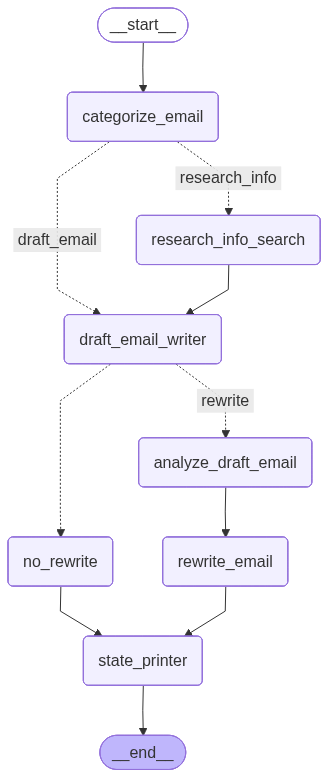

In [95]:
# Define the workflow (state graph)
workflow = StateGraph(GraphState)

# Add edges between nodes
workflow.add_edge("research_info_search", "draft_email_writer")     # After research, go to drafting

# Define the workflow (state graph)
workflow = StateGraph(GraphState)

# Add nodes to the workflow graph
workflow.add_node("categorize_email", categorize_email)  # Categorize the email
workflow.add_node("research_info_search", research_info_search)  # Perform web search for info
workflow.add_node("state_printer", state_printer)  # Print the final state
workflow.add_node("draft_email_writer", draft_email_writer)  # Generate draft email
workflow.add_node("analyze_draft_email", analyze_draft_email)  # Analyze the draft
workflow.add_node("rewrite_email", rewrite_email)  # Rewrite the email if necessary
workflow.add_node("no_rewrite", no_rewrite)  # No rewrite needed, just finalize

# Set the entry point to the "categorize_email" node
workflow.set_entry_point("categorize_email")

# Add conditional edges based on the outcome of the categorization
workflow.add_conditional_edges(
    "categorize_email",
    route_to_research,
    {
        "research_info": "research_info_search",  # If research info needed, go to research
        "draft_email": "draft_email_writer",  # If no research needed, go to draft email generation
    },
)

# Add edges between nodes
workflow.add_edge("research_info_search", "draft_email_writer")  # After research, go to drafting

# Add conditional edges based on whether the draft email needs rewriting or not
workflow.add_conditional_edges(
    "draft_email_writer",
    route_to_rewrite,
    {
        "rewrite": "analyze_draft_email",  # If rewrite needed, go to analyze draft
        "no_rewrite": "no_rewrite",  # If no rewrite needed, go to final email
    },
)

# Add edges to finalize the email or send for rewriting
workflow.add_edge("analyze_draft_email", "rewrite_email")  # After analyzing, rewrite the email
workflow.add_edge("no_rewrite", "state_printer")  # No rewrite, finalize the email
workflow.add_edge("rewrite_email", "state_printer")  # After rewriting, finalize the email

# Finally, add the end node
workflow.add_edge("state_printer", END)

# Compile the workflow into an executable application
app = workflow.compile()


# Show the workflow
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))



### Workflow Execution


In [96]:
EMAIL = """HI there, \n
I am emailing to say that I had a wonderful stay at your resort last week. \n


I really appreaciate what your staff did


Thanks,
Paul
"""


EMAIL = """HI there, \n
I am emailing to say that the resort weather was way to cloudy and overcast. \n
I wanted to write a song called 'Here comes the sun but it never came'


What should be the weather in Arizona in April?


I really hope you fix this next time.


Thanks,
George
"""


In [99]:
# Run the agent
inputs = {
    "initial_email": EMAIL,
    "research_info": None,
    "num_steps": 0,
    "info_needed": False  # Ensure this key is added
}


for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")


----CATEGORIZE INITIAL EMAIL----
customer_feedback
----ROUTE TO RESEARCH----
{'router_decision': 'research_info'}
research_info
---ROUTE EMAIL TO RESEARCH INFO---
'Finished running: categorize_email:'
---RESEARCH INFO SEARCHING---
Arizona weather April
[Document(metadata={}, page_content="Weather\n Archive\n Weather Widget\n\n World\n United States\n Arizona\n Weather in Phoenix\n\n# Weather in Phoenix in April 2025\n\nPhoenix Weather Forecast for April 2025 is based on statistical data.\n\nJanFebMarAprMayJunJulAugSepOctNovDec\n\n  \n\n## April\n\nStart Week On\n\n Sun\n Mon\n Tue\n Wed\n Thu\n Fri\n Sat\n\n +73°\n\n  16.6 mph W 28.5 inHg22 %06:14 am18:48 pm\n +63°\n\n  15.2 mph W 28.6 inHg33 %06:13 am18:49 pm\n +68°\n\n  +52°\n\n  9.8 mph S 28.7 inHg20 %06:12 am18:50 pm\n 4\n\n  +70°\n\n  +55° [...] 10.5 mph W 28.7 inHg22 %06:11 am18:51 pm\n 5\n\n  +77°\n\n  +57°\n\n  10.7 mph NW 28.9 inHg18 %06:09 am18:51 pm\n 6\n\n  +81°\n\n  +61°\n\n  10.1 mph W 28.9 inHg18 %06:08 am18:52 pm\n 7\n\

In [100]:
output = app.invoke(inputs)

print(output["final_email"])


----CATEGORIZE INITIAL EMAIL----
customer_feedback
----ROUTE TO RESEARCH----
{'router_decision': 'research_info'}
research_info
---ROUTE EMAIL TO RESEARCH INFO---
---RESEARCH INFO SEARCHING---
Arizona weather April
[Document(metadata={}, page_content="Weather\n Archive\n Weather Widget\n\n World\n United States\n Arizona\n Weather in Phoenix\n\n# Weather in Phoenix in April 2025\n\nPhoenix Weather Forecast for April 2025 is based on statistical data.\n\nJanFebMarAprMayJunJulAugSepOctNovDec\n\n  \n\n## April\n\nStart Week On\n\n Sun\n Mon\n Tue\n Wed\n Thu\n Fri\n Sat\n\n +73°\n\n  16.6 mph W 28.5 inHg22 %06:14 am18:48 pm\n +63°\n\n  15.2 mph W 28.6 inHg33 %06:13 am18:49 pm\n +68°\n\n  +52°\n\n  9.8 mph S 28.7 inHg20 %06:12 am18:50 pm\n 4\n\n  +70°\n\n  +55° [...] 10.5 mph W 28.7 inHg22 %06:11 am18:51 pm\n 5\n\n  +77°\n\n  +57°\n\n  10.7 mph NW 28.9 inHg18 %06:09 am18:51 pm\n 6\n\n  +81°\n\n  +61°\n\n  10.1 mph W 28.9 inHg18 %06:08 am18:52 pm\n 7\n\n  +86°\n\n  +61°\n\n  8.1 mph SW 28.9